In [1]:
import numpy as np
from colorama import Fore, Style

import torch
import torch.nn as nn

from transformers import RobertaTokenizer, Data2VecTextModel
from transformers import BertTokenizer, BertModel
from transformers import OpenAIGPTTokenizer, OpenAIGPTModel
# from transformers import GPT2Tokenizer, GPT2Model

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

from preprocessing.build_data_pipeline import build_data_pipeline

In [2]:
def normalize_last_hidden_state(out):
    out['last_hidden_state'] = torch.nn.functional.normalize(out['last_hidden_state'])

def numpify(X, out):
    X['attention_mask'] = X['attention_mask'].cpu().numpy()  # (B, L)
    out['last_hidden_state'] = out['last_hidden_state'].detach().cpu().numpy()  # (B, L, D)
    if 'pooler_output' in out.keys():
        out['pooler_output'] = out['pooler_output'].detach().cpu().numpy()
        
def aggregate_last_hidden_state(X, out, kind='numpy'):
    assert kind in ['numpy', 'pytorch']
    attention_mask = X['attention_mask'][:, :, None]
    out['last_hidden_state'] *= attention_mask
    
    if kind == 'numpy':
        out['last_hidden_state'] = np.sum(out['last_hidden_state'], axis=1)  # (B, D)
        out['last_hidden_state'] /= np.sum(attention_mask, axis=1)  # (B, D)
    else:
        out['last_hidden_state'] = torch.sum(out['last_hidden_state'], dim=1)  # (B, D)
        out['last_hidden_state'] /= torch.sum(attention_mask, dim=1)  # (B, D)
        
        
def freeze(model):
    for param in model.parameters():
        param.requires_grad = False

# Setup Data Pipeline

In [3]:
# settings 
device = torch.device(0)
batch_size = 128
num_workers = 0

# settings
N_way = 5
normalize = False  # l2-norm

In [4]:
# model, tokenizer
# model = Data2VecTextModel.from_pretrained("facebook/data2vec-text-base")
# tokenizer = RobertaTokenizer.from_pretrained("facebook/data2vec-text-base")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model = model.to(device);

freeze(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# data loader
train_data_loader, test_data_loader = build_data_pipeline(batch_size, num_workers, tokenizer)

# TSNE on Vectors by TF-IDF 

In [55]:
corpus = test_data_loader.dataset.X.tolist()

def tsne_tfidf(vectorizer: TfidfVectorizer):
    # vectorize
    X = vectorizer.fit_transform(corpus)
    Y = test_data_loader.dataset.Y.values

    # TSNE
    zs_emb = TSNE(n_components=2, learning_rate='auto', init='random', random_state=1, n_jobs=-1).fit_transform(X)
    plt.figure(figsize=(5, 5))
    plt.scatter(zs_emb[:,0], zs_emb[:,1], c=Y, alpha=0.1, cmap='coolwarm');
    
def pca_tfidf(vectorizer: TfidfVectorizer):
    # vectorize
    X = vectorizer.fit_transform(corpus)
    Y = test_data_loader.dataset.Y.values
    
    for alpha in [0.1, 0.02]:
        zs_emb = PCA(n_components=2, ).fit_transform(X.toarray())
        plt.figure(figsize=(5, 5))
        plt.scatter(zs_emb[:,0], zs_emb[:,1], c=Y, alpha=alpha, cmap='coolwarm');

In [56]:
max_features = 300

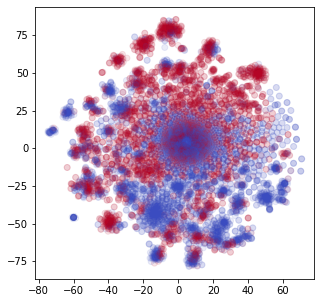

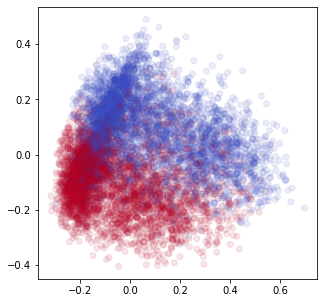

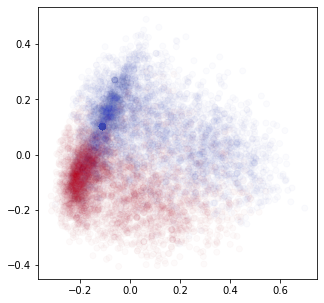

In [57]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features, ngram_range=(1,1))
tsne_tfidf(vectorizer)
pca_tfidf(vectorizer)

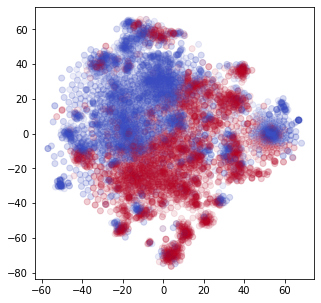

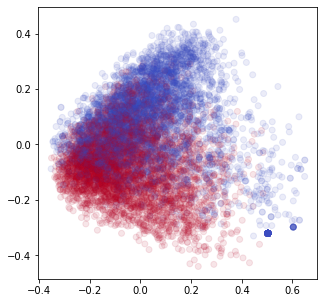

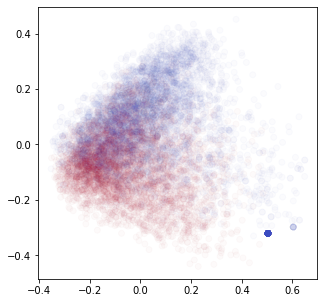

In [58]:
vectorizer = TfidfVectorizer(stop_words=None, max_features=max_features, ngram_range=(1,1))
tsne_tfidf(vectorizer)
pca_tfidf(vectorizer)

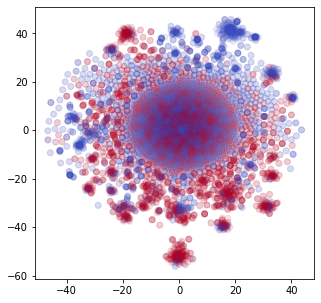

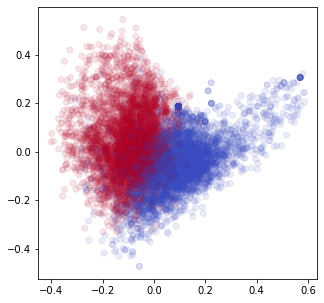

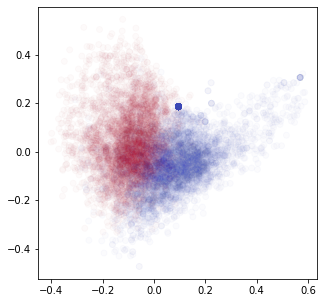

In [59]:
vectorizer = TfidfVectorizer(stop_words=None, max_features=max_features, ngram_range=(2,2))
tsne_tfidf(vectorizer)
pca_tfidf(vectorizer)

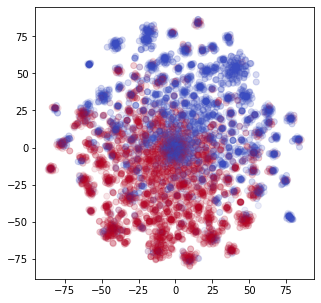

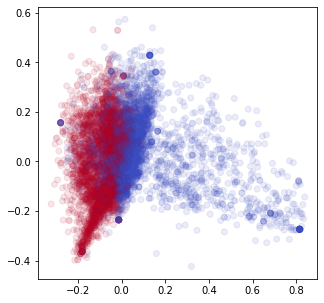

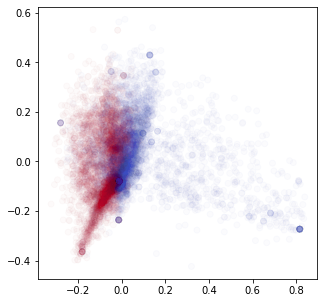

In [60]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features, ngram_range=(2,2))
tsne_tfidf(vectorizer)
pca_tfidf(vectorizer)

# Linear Evaluation
- Input: vectors from TF-IDF

In [95]:
vectorizer = TfidfVectorizer(stop_words=None, max_features=max_features, ngram_range=(2,2))
corpus = train_data_loader.dataset.X.tolist()
vectorizer.fit(corpus);

In [96]:
# data loader
batch_size = 128
num_workers = 12
train_data_loader, test_data_loader = build_data_pipeline(batch_size, num_workers, tokenizer)

In [97]:
# linear clf head
dim = max_features
linear = nn.Linear(dim, 2)
linear = linear.to(device)

# compile
n_epochs = 2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(linear.parameters(), lr=1e-3, weight_decay=1e-5)
T_max = int(np.ceil(len(train_data_loader.dataset) // batch_size)) * n_epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

print(T_max)

560


In [98]:
# train
steps = 0
for epoch in range(n_epochs):
    print('EPOCH:', epoch)
    for i, batch in enumerate(train_data_loader):
        optimizer.zero_grad()
        
        sents, X, Y = batch  # fetch data
        out = {}
        last_hidden_state = vectorizer.transform(list(sents)).toarray()  # (B, D)
        out['last_hidden_state'] = torch.from_numpy(last_hidden_state).float().to(device)  # (B, D)
        
        out = linear(out['last_hidden_state'])
        loss = criterion(out.squeeze().float(), Y.to(device).long())
                
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # verbose
        steps += 1
        current_lr = optimizer.param_groups[0]['lr']
        print(f'step: {steps}, train/loss.step: {round(loss.item(), 5)}, lr: {current_lr}')        

EPOCH: 0
step: 1, train/loss.step: 0.7024, lr: 0.0009999921320324326
step: 2, train/loss.step: 0.69744, lr: 0.0009999685283773503
step: 3, train/loss.step: 0.70031, lr: 0.000999929189777604
step: 4, train/loss.step: 0.69144, lr: 0.0009998741174712532
step: 5, train/loss.step: 0.69465, lr: 0.0009998033131915264
step: 6, train/loss.step: 0.69391, lr: 0.0009997167791667666
step: 7, train/loss.step: 0.69039, lr: 0.0009996145181203613
step: 8, train/loss.step: 0.68603, lr: 0.0009994965332706571
step: 9, train/loss.step: 0.68266, lr: 0.0009993628283308578
step: 10, train/loss.step: 0.68984, lr: 0.000999213407508908
step: 11, train/loss.step: 0.68939, lr: 0.0009990482755073602
step: 12, train/loss.step: 0.68728, lr: 0.0009988674375232276
step: 13, train/loss.step: 0.68572, lr: 0.0009986708992478198
step: 14, train/loss.step: 0.68099, lr: 0.0009984586668665635
step: 15, train/loss.step: 0.68031, lr: 0.000998230747058809
step: 16, train/loss.step: 0.68198, lr: 0.000997987146997619
step: 17, tra

step: 134, train/loss.step: 0.5771, lr: 0.0008652514554406379
step: 135, train/loss.step: 0.5821, lr: 0.0008633301610170127
step: 136, train/loss.step: 0.57992, lr: 0.000861397431913695
step: 137, train/loss.step: 0.58171, lr: 0.0008594533289572844
step: 138, train/loss.step: 0.58107, lr: 0.0008574979133323369
step: 139, train/loss.step: 0.58516, lr: 0.0008555312465794395
step: 140, train/loss.step: 0.58165, lr: 0.000853553390593273
step: 141, train/loss.step: 0.5763, lr: 0.0008515644076206644
step: 142, train/loss.step: 0.60139, lr: 0.0008495643602586279
step: 143, train/loss.step: 0.58892, lr: 0.0008475533114523946
step: 144, train/loss.step: 0.5876, lr: 0.0008455313244934315
step: 145, train/loss.step: 0.56915, lr: 0.0008434984630174499
step: 146, train/loss.step: 0.5697, lr: 0.0008414547910024026
step: 147, train/loss.step: 0.57812, lr: 0.0008394003727664702
step: 148, train/loss.step: 0.58401, lr: 0.0008373352729660364
step: 149, train/loss.step: 0.58805, lr: 0.0008352595565936546

step: 265, train/loss.step: 0.52036, lr: 0.000542025262464623
step: 266, train/loss.step: 0.52692, lr: 0.0005392295478639217
step: 267, train/loss.step: 0.53131, lr: 0.0005364325986359793
step: 268, train/loss.step: 0.52316, lr: 0.0005336345028060191
step: 269, train/loss.step: 0.52654, lr: 0.0005308353484353499
step: 270, train/loss.step: 0.52314, lr: 0.000528035223618595
step: 271, train/loss.step: 0.5326, lr: 0.0005252342164809195
step: 272, train/loss.step: 0.51327, lr: 0.0005224324151752567
step: 273, train/loss.step: 0.52964, lr: 0.0005196299078795335
step: 274, train/loss.step: 0.50441, lr: 0.0005168267827938962
step: 275, train/loss.step: 0.51906, lr: 0.0005140231281379336
step: 276, train/loss.step: 0.55771, lr: 0.0005112190321479017
step: 277, train/loss.step: 0.50584, lr: 0.0005084145830739454
step: 278, train/loss.step: 0.51774, lr: 0.0005056098691773222
step: 279, train/loss.step: 0.51667, lr: 0.000502804978727624
step: 280, train/loss.step: 0.51029, lr: 0.0004999999999999

step: 395, train/loss.step: 0.49865, lr: 0.00019934145435079677
step: 396, train/loss.step: 0.47911, lr: 0.00019710497807958968
step: 397, train/loss.step: 0.50335, lr: 0.00019487803448121785
step: 398, train/loss.step: 0.52407, lr: 0.00019266069364176102
step: 399, train/loss.step: 0.51164, lr: 0.00019045302534508274
step: 400, train/loss.step: 0.48906, lr: 0.00018825509907063287
step: 401, train/loss.step: 0.4834, lr: 0.00018606698399126236
step: 402, train/loss.step: 0.5059, lr: 0.0001838887489710448
step: 403, train/loss.step: 0.49653, lr: 0.00018172046256311047
step: 404, train/loss.step: 0.48406, lr: 0.00017956219300748754
step: 405, train/loss.step: 0.49423, lr: 0.0001774140082289559
step: 406, train/loss.step: 0.49051, lr: 0.00017527597583490783
step: 407, train/loss.step: 0.48104, lr: 0.0001731481631132216
step: 408, train/loss.step: 0.49421, lr: 0.00017103063703014336
step: 409, train/loss.step: 0.49589, lr: 0.0001689234642281789
step: 410, train/loss.step: 0.49731, lr: 0.000

step: 526, train/loss.step: 0.48385, lr: 9.067852381940778e-06
step: 527, train/loss.step: 0.48411, lr: 8.543795518357746e-06
step: 528, train/loss.step: 0.47547, lr: 8.035205700685147e-06
step: 529, train/loss.step: 0.4776, lr: 7.5420989351958995e-06
step: 530, train/loss.step: 0.49143, lr: 7.06449074088204e-06
step: 531, train/loss.step: 0.48391, lr: 6.602396148966778e-06
step: 532, train/loss.step: 0.49654, lr: 6.155829702431156e-06
step: 533, train/loss.step: 0.48328, lr: 5.7248054555563564e-06
step: 534, train/loss.step: 0.48913, lr: 5.309336973481669e-06
step: 535, train/loss.step: 0.49589, lr: 4.909437331777165e-06
step: 536, train/loss.step: 0.47822, lr: 4.525119116032638e-06
step: 537, train/loss.step: 0.50242, lr: 4.156394421460919e-06
step: 538, train/loss.step: 0.48504, lr: 3.8032748525179584e-06
step: 539, train/loss.step: 0.48698, lr: 3.4657715225368446e-06
step: 540, train/loss.step: 0.49068, lr: 3.14389505337869e-06
step: 541, train/loss.step: 0.48637, lr: 2.83765557509

In [99]:
# empty cuda cache
del X, Y
torch.cuda.empty_cache()

In [100]:
# test
acc_score = 0
n_test_samples = 0
for i, batch in enumerate(test_data_loader):
    print(round(i/len(test_data_loader) * 100, 1), '%')
    
    sents, X, Y = batch  # fetch data
    X = X.to(device)
    out = {}
    last_hidden_state = vectorizer.transform(list(sents)).toarray()  # (B, D)
    out['last_hidden_state'] = torch.from_numpy(last_hidden_state).float().to(device)  # (B, D)

    out = linear(out['last_hidden_state'])
    loss = criterion(out.squeeze().float(), Y.to(device).long())
    out = torch.softmax(out, dim=1)
    out = torch.argmax(out, dim=1)

    out = out.squeeze().detach().cpu().numpy()
    Y = Y.numpy()
    
    acc_score += accuracy_score(Y, out, normalize=False)
    n_test_samples += len(Y)
    
    print(f'test/loss.step: {round(loss.item(), 5)}')

0.0 %
test/loss.step: 0.49013
1.4 %
test/loss.step: 0.48255
2.8 %
test/loss.step: 0.48315
4.2 %
test/loss.step: 0.48631
5.6 %
test/loss.step: 0.48145
7.0 %
test/loss.step: 0.47846
8.5 %
test/loss.step: 0.49484
9.9 %
test/loss.step: 0.49887
11.3 %
test/loss.step: 0.48692
12.7 %
test/loss.step: 0.49239
14.1 %
test/loss.step: 0.48724
15.5 %
test/loss.step: 0.4834
16.9 %
test/loss.step: 0.48103
18.3 %
test/loss.step: 0.47031
19.7 %
test/loss.step: 0.47811
21.1 %
test/loss.step: 0.46519
22.5 %
test/loss.step: 0.47771
23.9 %
test/loss.step: 0.5054
25.4 %
test/loss.step: 0.49344
26.8 %
test/loss.step: 0.49514
28.2 %
test/loss.step: 0.51029
29.6 %
test/loss.step: 0.48246
31.0 %
test/loss.step: 0.49787
32.4 %
test/loss.step: 0.49244
33.8 %
test/loss.step: 0.48746
35.2 %
test/loss.step: 0.49784
36.6 %
test/loss.step: 0.49055
38.0 %
test/loss.step: 0.46855
39.4 %
test/loss.step: 0.48651
40.8 %
test/loss.step: 0.52158
42.3 %
test/loss.step: 0.48436
43.7 %
test/loss.step: 0.50388
45.1 %
test/loss.s

In [101]:
# empty cuda cache
del X, Y, out
torch.cuda.empty_cache()

In [102]:
print("TEST ACC:", round(acc_score / n_test_samples, 3))

TEST ACC: 0.908


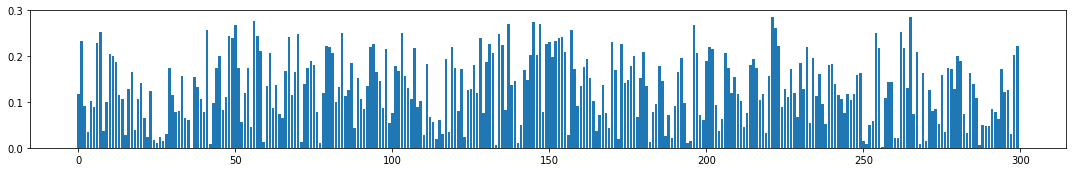

In [114]:
# check weight of the linear layer

weight_fake = linear.weight.data[0,:].cpu().numpy()
weight_real = linear.weight.data[1,:].cpu().numpy()

x_rng = np.arange(weight_fake.shape[0])

plt.figure(figsize=(15, 2.5))
#plt.bar(x_rng, weight_fake)
plt.bar(x_rng, np.abs(weight_real))
plt.tight_layout();

# TSNE on Glove vectors

In [29]:
import nltk
import gensim
import gensim.downloader
from torch.utils.data import Dataset, DataLoader

import pandas as pd
from utils import root_dir
from sklearn.model_selection import train_test_split
import nltk

# from preprocessing.preprocess import FakeNewsDatasetGlove

In [30]:
# check available pre-trained embeddings
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [39]:
# fetch the pretrained embedding
# glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')
glove_vectors = gensim.downloader.load('word2vec-google-news-300')

In [40]:
class FakeNewsDatasetGlove(Dataset):
    def __init__(self,
                 kind: str,
                 glove_vectors,
                 embedding,
                 train_test_split_rseed=1,
                 in_col='text',
                 max_len=None,
                 device=None,
                 **kwargs
                 ):
        super().__init__()
        assert kind in ['train', 'test']
        assert in_col in ['text', 'title']
        self.kind = kind
        # self.tokenizer = tokenizer
        self.glove_vectors = glove_vectors
        self.max_len = max_len
        self.in_col = in_col
        self.device = device

        # emb weight - Glove
        self.embedding = embedding

        true = pd.read_csv(root_dir.joinpath('data', 'True.csv'))
        false = pd.read_csv(root_dir.joinpath('data', 'Fake.csv'))

        # provide numeric label: {True: 1, Fake: 0}
        true['category'] = 1
        false['category'] = 0

        # Merging the 2 datasets
        self.df = pd.concat([true, false])

        # clean
        self.df['text'] = self.df['text'].apply(self.clean_text)

        # split
        X_train, X_test, y_train, y_test = train_test_split(self.df[in_col],
                                                            self.df['category'],
                                                            train_size=0.8,
                                                            test_size=0.2,
                                                            random_state=train_test_split_rseed)
        self.X = X_train if self.kind == 'train' else X_test
        self.Y = y_train if self.kind == 'train' else y_test

        self.len = self.X.shape[0]

    def clean_text(self, text):
        text = text.split('(Reuters) - ')[-1]  # remove '(Reuters)' to make the task less trivial.
        text = text.strip()
        text = text.lower()
        return text

    def key_to_index(self, word_token: str):
        try:
            return self.glove_vectors.key_to_index[word_token]
        except:
            return -1

    def __getitem__(self, idx):
        sent = self.X.iloc[idx]
        y = self.Y.iloc[idx]

        # tokenize
        ind = [self.key_to_index(wt.strip()) for wt in nltk.word_tokenize(sent)[:self.max_len]]
        ind = np.array(ind)
        ind = ind[ind != -1]
        ind = torch.Tensor(ind).int()
        #print(ind)
        
        # emb vector
        z = self.embedding(ind.to(self.device))  # (L, D)
        
        # aggregate along L
        z = z.mean(dim=0)  # (D,)
        
        return z, y

    def __len__(self):
        return self.len

In [41]:
# load pre-trained emb weight
emb_weights = torch.FloatTensor(glove_vectors.vectors)
vocab_size, emb_dim = emb_weights.shape
# embedding = nn.Embedding(num_embeddings=vocab_size + 1, embedding_dim=emb_dim)  # +1 for mask-token
embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim)  # +1 for mask-token
# embedding.weight[:vocab_size, :].data = emb_weights
embedding.weight.data = emb_weights
embedding = embedding.to(device)
for param in embedding.parameters():
    param.requires_grad = False
    
print(embedding.weight.shape)

torch.Size([3000000, 300])


In [42]:
length = 512
batch_size = 128
num_workers = 0

train_dataset = FakeNewsDatasetGlove('train', glove_vectors, embedding, max_len=length, device=device)
test_dataset = FakeNewsDatasetGlove('test', glove_vectors, embedding, max_len=length, device=device)
train_data_loader = DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               drop_last=True,
                               num_workers=num_workers,
                               pin_memory=True if num_workers > 0 else False)
test_data_loader = DataLoader(test_dataset,
                              batch_size=batch_size,
                              shuffle=False,
                              drop_last=False,
                              num_workers=num_workers,
                              pin_memory=True if num_workers > 0 else False)

In [43]:
z_tests = {'real': [], 'fake': []}  # z: representation
for batch in test_data_loader:
    z, y = batch  # z: (B, D), y: (B,)
    
    # remove nan if there is
    ind = (z.isnan() == False)[:, 0]
    #print((z.isnan() == True)[:, 0].sum().cpu().item())
    z = z[ind, :]
    y = y[ind]
        
    # store
    z = z.cpu().detach().numpy()
    
    B = z.shape[0]
    for b in range(B):
        if np.isnan(z[b]).sum() > 0:
            continue
        z_tests['fake' if y[b] == 0 else 'real'].append(z[b])
    
# numpify
z_tests['real'] = np.array(z_tests['real'])  # (B, D)
z_tests['fake'] = np.array(z_tests['fake'])  # (B, D)

In [44]:
del z, y
torch.cuda.empty_cache()

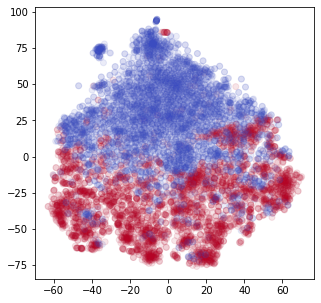

In [151]:
# TSNE
zs = np.concatenate((z_tests['real'], z_tests['fake']))
label_zs = np.array([1] * z_tests['real'].shape[0] + [0] * z_tests['fake'].shape[0])
zs_emb = TSNE(n_components=2, learning_rate='auto', init='random', random_state=1).fit_transform(zs)

plt.figure(figsize=(5, 5))
plt.scatter(zs_emb[:,0], zs_emb[:,1], c=label_zs, alpha=0.1, cmap='coolwarm');

In [45]:
zs = np.concatenate((z_tests['real'], z_tests['fake']))
label_zs = np.array([1] * z_tests['real'].shape[0] + [0] * z_tests['fake'].shape[0])

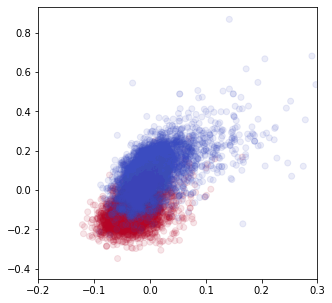

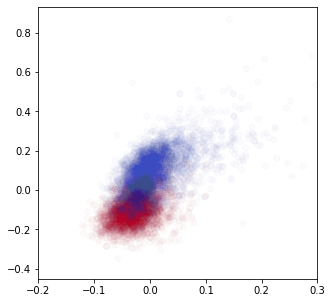

In [48]:
# PCA
zs_emb = PCA(n_components=2).fit_transform(zs)

for alpha in [0.1, 0.02]:
    plt.figure(figsize=(5, 5))
    plt.scatter(zs_emb[:,0], zs_emb[:,1], c=label_zs, alpha=alpha, cmap='coolwarm');
    plt.xlim(-0.2, 0.3);
#     plt.ylim(-1.1, 2.);

# Linear Evaluation on Glove

In [157]:
# linear clf head
dim = glove_vectors.vector_size
linear = nn.Linear(dim, 2)
linear = linear.to(device)

# compile
n_epochs = 2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(linear.parameters(), lr=1e-3, weight_decay=1e-5)
T_max = int(np.ceil(len(train_data_loader.dataset) // batch_size)) * n_epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

print(T_max)

560


In [119]:
# train
# embeddings = model.embeddings.word_embeddings.to(device)
steps = 0
for epoch in range(n_epochs):
    print('EPOCH:', epoch)
    
    acc_score = 0
    n_test_samples = 0
    for i, batch in enumerate(train_data_loader):
        optimizer.zero_grad()
        
        z, y = batch  # z: (B, D); y: (B,)
        
        # remove nan if there is
        ind = (z.isnan() == False)[:, 0]
        z = z[ind, :]
        y = y[ind]
        
        out = linear(z.to(device))  # (B, 2)
        
        loss = criterion(out.squeeze().float(), y.to(device).long())
                
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # verbose
        steps += 1
        current_lr = optimizer.param_groups[0]['lr']
        print(f'step: {steps}, train/loss.step: {round(loss.item(), 5)}, lr: {current_lr}')
        
        out = torch.argmax(out, dim=1)
        acc_score += accuracy_score(y.numpy(), out.detach().cpu().numpy(), normalize=False)
        n_test_samples += len(y)
    print("TRAIN ACC:", round(acc_score / n_test_samples, 3))

EPOCH: 0
step: 1, train/loss.step: 0.68947, lr: 0.0009999921320324326
step: 2, train/loss.step: 0.68992, lr: 0.0009999685283773503
step: 3, train/loss.step: 0.68798, lr: 0.000999929189777604
step: 4, train/loss.step: 0.6863, lr: 0.0009998741174712532
step: 5, train/loss.step: 0.6839, lr: 0.0009998033131915264
step: 6, train/loss.step: 0.68273, lr: 0.0009997167791667666
step: 7, train/loss.step: 0.68185, lr: 0.0009996145181203613
step: 8, train/loss.step: 0.67849, lr: 0.0009994965332706571
step: 9, train/loss.step: 0.67865, lr: 0.0009993628283308578
step: 10, train/loss.step: 0.67702, lr: 0.000999213407508908
step: 11, train/loss.step: 0.67767, lr: 0.0009990482755073602
step: 12, train/loss.step: 0.67344, lr: 0.0009988674375232276
step: 13, train/loss.step: 0.67156, lr: 0.0009986708992478198
step: 14, train/loss.step: 0.6739, lr: 0.0009984586668665635
step: 15, train/loss.step: 0.67463, lr: 0.000998230747058809
step: 16, train/loss.step: 0.67554, lr: 0.000997987146997619
step: 17, train

step: 134, train/loss.step: 0.57131, lr: 0.0008652514554406379
step: 135, train/loss.step: 0.56497, lr: 0.0008633301610170127
step: 136, train/loss.step: 0.57164, lr: 0.000861397431913695
step: 137, train/loss.step: 0.58325, lr: 0.0008594533289572844
step: 138, train/loss.step: 0.57467, lr: 0.0008574979133323369
step: 139, train/loss.step: 0.56184, lr: 0.0008555312465794395
step: 140, train/loss.step: 0.57347, lr: 0.000853553390593273
step: 141, train/loss.step: 0.55189, lr: 0.0008515644076206644
step: 142, train/loss.step: 0.5756, lr: 0.0008495643602586279
step: 143, train/loss.step: 0.56067, lr: 0.0008475533114523946
step: 144, train/loss.step: 0.565, lr: 0.0008455313244934315
step: 145, train/loss.step: 0.56435, lr: 0.0008434984630174499
step: 146, train/loss.step: 0.58712, lr: 0.0008414547910024026
step: 147, train/loss.step: 0.55104, lr: 0.0008394003727664702
step: 148, train/loss.step: 0.5715, lr: 0.0008373352729660364
step: 149, train/loss.step: 0.57206, lr: 0.000835259556593654

step: 265, train/loss.step: 0.49867, lr: 0.000542025262464623
step: 266, train/loss.step: 0.51865, lr: 0.0005392295478639217
step: 267, train/loss.step: 0.54246, lr: 0.0005364325986359793
step: 268, train/loss.step: 0.51617, lr: 0.0005336345028060191
step: 269, train/loss.step: 0.50159, lr: 0.0005308353484353499
step: 270, train/loss.step: 0.51892, lr: 0.000528035223618595
step: 271, train/loss.step: 0.52748, lr: 0.0005252342164809195
step: 272, train/loss.step: 0.50733, lr: 0.0005224324151752567
step: 273, train/loss.step: 0.50441, lr: 0.0005196299078795335
step: 274, train/loss.step: 0.51941, lr: 0.0005168267827938962
step: 275, train/loss.step: 0.51982, lr: 0.0005140231281379336
step: 276, train/loss.step: 0.51561, lr: 0.0005112190321479017
step: 277, train/loss.step: 0.50289, lr: 0.0005084145830739454
step: 278, train/loss.step: 0.51683, lr: 0.0005056098691773222
step: 279, train/loss.step: 0.52992, lr: 0.000502804978727624
step: 280, train/loss.step: 0.54047, lr: 0.000499999999999

step: 395, train/loss.step: 0.49443, lr: 0.00019934145435079677
step: 396, train/loss.step: 0.48099, lr: 0.00019710497807958968
step: 397, train/loss.step: 0.46064, lr: 0.00019487803448121785
step: 398, train/loss.step: 0.47436, lr: 0.00019266069364176102
step: 399, train/loss.step: 0.46829, lr: 0.00019045302534508274
step: 400, train/loss.step: 0.48027, lr: 0.00018825509907063287
step: 401, train/loss.step: 0.45189, lr: 0.00018606698399126236
step: 402, train/loss.step: 0.48026, lr: 0.0001838887489710448
step: 403, train/loss.step: 0.47594, lr: 0.00018172046256311047
step: 404, train/loss.step: 0.48815, lr: 0.00017956219300748754
step: 405, train/loss.step: 0.48313, lr: 0.0001774140082289559
step: 406, train/loss.step: 0.48287, lr: 0.00017527597583490783
step: 407, train/loss.step: 0.48731, lr: 0.0001731481631132216
step: 408, train/loss.step: 0.48647, lr: 0.00017103063703014336
step: 409, train/loss.step: 0.46232, lr: 0.0001689234642281789
step: 410, train/loss.step: 0.4751, lr: 0.00

step: 525, train/loss.step: 0.45286, lr: 9.607359798384762e-06
step: 526, train/loss.step: 0.47096, lr: 9.067852381940778e-06
step: 527, train/loss.step: 0.48357, lr: 8.543795518357746e-06
step: 528, train/loss.step: 0.47741, lr: 8.035205700685147e-06
step: 529, train/loss.step: 0.46756, lr: 7.5420989351958995e-06
step: 530, train/loss.step: 0.46959, lr: 7.06449074088204e-06
step: 531, train/loss.step: 0.50362, lr: 6.602396148966778e-06
step: 532, train/loss.step: 0.44833, lr: 6.155829702431156e-06
step: 533, train/loss.step: 0.46779, lr: 5.7248054555563564e-06
step: 534, train/loss.step: 0.47842, lr: 5.309336973481669e-06
step: 535, train/loss.step: 0.483, lr: 4.909437331777165e-06
step: 536, train/loss.step: 0.46558, lr: 4.525119116032638e-06
step: 537, train/loss.step: 0.47082, lr: 4.156394421460919e-06
step: 538, train/loss.step: 0.46856, lr: 3.8032748525179584e-06
step: 539, train/loss.step: 0.47165, lr: 3.4657715225368446e-06
step: 540, train/loss.step: 0.52264, lr: 3.14389505337

In [120]:
# empty cuda cache
del z, y, out
torch.cuda.empty_cache()

In [121]:
# test
acc_score = 0
n_test_samples = 0
for i, batch in enumerate(test_data_loader):
    print(round(i/len(test_data_loader) * 100, 1), '%')
    
    z, y = batch  # z: (B, D); y: (B,)
        
    # remove nan if there is
    ind = (z.isnan() == False)[:, 0]
    z = z[ind, :]
    y = y[ind]

    out = linear(z.to(device))  # (B, 2)
    
    loss = criterion(out.squeeze().float(), y.to(device).long())
    print(f'test/loss.step: {round(loss.item(), 5)}')
    
    out = torch.argmax(out, dim=1)
    out = out.squeeze().detach().cpu().numpy()
    y = y.numpy()
    
    acc_score += accuracy_score(y, out, normalize=False)
    n_test_samples += len(y)

0.0 %
test/loss.step: 0.48762
1.4 %
test/loss.step: 0.45478
2.8 %
test/loss.step: 0.49598
4.2 %
test/loss.step: 0.47109
5.6 %
test/loss.step: 0.4978
7.0 %
test/loss.step: 0.47753
8.5 %
test/loss.step: 0.50323
9.9 %
test/loss.step: 0.48255
11.3 %
test/loss.step: 0.46047
12.7 %
test/loss.step: 0.48979
14.1 %
test/loss.step: 0.48486
15.5 %
test/loss.step: 0.46205
16.9 %
test/loss.step: 0.48075
18.3 %
test/loss.step: 0.486
19.7 %
test/loss.step: 0.48781
21.1 %
test/loss.step: 0.47489
22.5 %
test/loss.step: 0.46168
23.9 %
test/loss.step: 0.47365
25.4 %
test/loss.step: 0.48028
26.8 %
test/loss.step: 0.48803
28.2 %
test/loss.step: 0.48375
29.6 %
test/loss.step: 0.47543
31.0 %
test/loss.step: 0.46219
32.4 %
test/loss.step: 0.49342
33.8 %
test/loss.step: 0.49261
35.2 %
test/loss.step: 0.48088
36.6 %
test/loss.step: 0.48107
38.0 %
test/loss.step: 0.47233
39.4 %
test/loss.step: 0.49116
40.8 %
test/loss.step: 0.49957
42.3 %
test/loss.step: 0.457
43.7 %
test/loss.step: 0.47635
45.1 %
test/loss.step

In [122]:
# empty cuda cache
del z, y, out
torch.cuda.empty_cache()

In [123]:
print("TEST ACC:", round(acc_score / n_test_samples, 3))

TEST ACC: 0.888


# TSNE on Tokens from a Pretrained Tokenizer

In [22]:
batch_size = 128
num_workers = 12
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_data_loader, test_data_loader = build_data_pipeline(batch_size, num_workers, tokenizer)# re-initialize `tokenizer`

In [23]:
embeddings = model.embeddings.word_embeddings.cpu()
for param in embeddings.parameters():
    param.requires_grad = False

In [24]:
z_tests = {'real': [], 'fake': []}  # z: representation
count = 0
for batch in test_data_loader:
    print('{:0.1f}% is processed.'.format(count/len(test_data_loader.dataset) * 100))
    sents, X, Y = batch  # X: (B, L)
    out = {}
    out['last_hidden_state'] = embeddings(X['input_ids'])  # (B, L, D)
    aggregate_last_hidden_state(X, out, kind='pytorch')
    
    # store
    for i, y in enumerate(Y):
        y = y.item()
        z_tests['fake' if y == 0 else 'real'].append(out['last_hidden_state'][i].detach().numpy())
    
    count += Y.shape[0]
        
# numpify
z_tests['real'] = np.array(z_tests['real'])  # (B, D)
z_tests['fake'] = np.array(z_tests['fake'])  # (B, D)

0.0% is processed.
1.4% is processed.
2.9% is processed.
4.3% is processed.
5.7% is processed.
7.1% is processed.
8.6% is processed.
10.0% is processed.
11.4% is processed.
12.8% is processed.
14.3% is processed.
15.7% is processed.
17.1% is processed.
18.5% is processed.
20.0% is processed.
21.4% is processed.
22.8% is processed.
24.2% is processed.
25.7% is processed.
27.1% is processed.
28.5% is processed.
29.9% is processed.
31.4% is processed.
32.8% is processed.
34.2% is processed.
35.6% is processed.
37.1% is processed.
38.5% is processed.
39.9% is processed.
41.3% is processed.
42.8% is processed.
44.2% is processed.
45.6% is processed.
47.0% is processed.
48.5% is processed.
49.9% is processed.
51.3% is processed.
52.7% is processed.
54.2% is processed.
55.6% is processed.
57.0% is processed.
58.4% is processed.
59.9% is processed.
61.3% is processed.
62.7% is processed.
64.1% is processed.
65.6% is processed.
67.0% is processed.
68.4% is processed.
69.8% is processed.
71.3% i

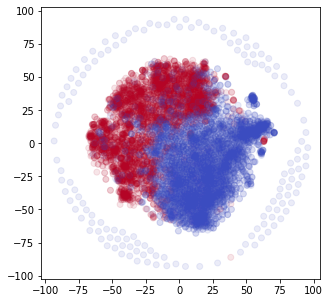

In [169]:
# TSNE
zs = np.concatenate((z_tests['real'], z_tests['fake']))
label_zs = np.array([1] * z_tests['real'].shape[0] + [0] * z_tests['fake'].shape[0])
zs_emb = TSNE(n_components=2, learning_rate='auto', init='random', random_state=1, n_jobs=-1).fit_transform(zs)

plt.figure(figsize=(5, 5))
plt.scatter(zs_emb[:,0], zs_emb[:,1], c=label_zs, alpha=0.1, cmap='coolwarm');

In [25]:
zs = np.concatenate((z_tests['real'], z_tests['fake']))
label_zs = np.array([1] * z_tests['real'].shape[0] + [0] * z_tests['fake'].shape[0])

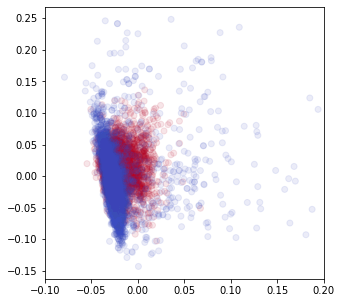

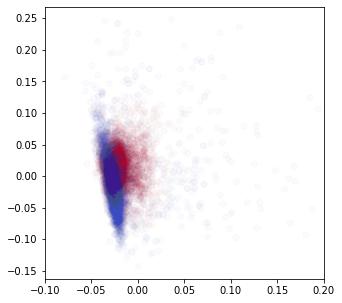

In [27]:
# PCA
zs_emb = PCA(n_components=2).fit_transform(zs)

for alpha in [0.1, 0.02]:
    plt.figure(figsize=(5, 5))
    plt.scatter(zs_emb[:,0], zs_emb[:,1], c=label_zs, alpha=alpha, cmap='coolwarm');
    plt.xlim(-0.1, 0.2); 
    # plt.ylim(-1.1, 2.);

# Linear Evaluation
- Input: aggregated embedding vectors

In [129]:
batch_size = 128
num_workers = 12
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_data_loader, test_data_loader = build_data_pipeline(batch_size, num_workers, tokenizer)# re-initialize `tokenizer`

In [130]:
# linear clf head
dim = 768
linear = nn.Linear(dim, 2)
linear = linear.to(device)

# compile
n_epochs = 2
criterion = nn.CrossEntropyLoss()  #nn.BCEWithLogitsLoss() 
optimizer = torch.optim.AdamW(linear.parameters(), lr=1e-3, weight_decay=1e-5)
T_max = int(np.ceil(len(train_data_loader.dataset) // batch_size)) * n_epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

print(T_max)

560


In [131]:
embeddings = model.embeddings.word_embeddings.to(device)
for param in embeddings.parameters():
    param.requires_grad = False

In [132]:
# train

steps = 0
for epoch in range(n_epochs):
    print('EPOCH:', epoch)
    for i, batch in enumerate(train_data_loader):
        optimizer.zero_grad()
        
        sents, X, Y = batch  # fetch data
        X = X.to(device)
        out = {}
        out['last_hidden_state'] = embeddings(X['input_ids'])  # (B, L, D)
        aggregate_last_hidden_state(X, out, kind='pytorch')
        
        out = linear(out['last_hidden_state'])
        loss = criterion(out.squeeze().float(), Y.to(device).long())
                
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # verbose
        steps += 1
        current_lr = optimizer.param_groups[0]['lr']
        print(f'step: {steps}, train/loss.step: {round(loss.item(), 5)}, lr: {current_lr}')        

EPOCH: 0
step: 1, train/loss.step: 0.69292, lr: 0.0009999921320324326
step: 2, train/loss.step: 0.69317, lr: 0.0009999685283773503
step: 3, train/loss.step: 0.69505, lr: 0.000999929189777604
step: 4, train/loss.step: 0.69208, lr: 0.0009998741174712532
step: 5, train/loss.step: 0.69702, lr: 0.0009998033131915264
step: 6, train/loss.step: 0.696, lr: 0.0009997167791667666
step: 7, train/loss.step: 0.69346, lr: 0.0009996145181203613
step: 8, train/loss.step: 0.69481, lr: 0.0009994965332706571
step: 9, train/loss.step: 0.69336, lr: 0.0009993628283308578
step: 10, train/loss.step: 0.69361, lr: 0.000999213407508908
step: 11, train/loss.step: 0.69437, lr: 0.0009990482755073602
step: 12, train/loss.step: 0.69028, lr: 0.0009988674375232276
step: 13, train/loss.step: 0.69257, lr: 0.0009986708992478198
step: 14, train/loss.step: 0.69131, lr: 0.0009984586668665635
step: 15, train/loss.step: 0.69121, lr: 0.000998230747058809
step: 16, train/loss.step: 0.69127, lr: 0.000997987146997619
step: 17, trai

step: 139, train/loss.step: 0.66813, lr: 0.0008555312465794395
step: 140, train/loss.step: 0.6697, lr: 0.000853553390593273
step: 141, train/loss.step: 0.66574, lr: 0.0008515644076206644
step: 142, train/loss.step: 0.67076, lr: 0.0008495643602586279
step: 143, train/loss.step: 0.66946, lr: 0.0008475533114523946
step: 144, train/loss.step: 0.66193, lr: 0.0008455313244934315
step: 145, train/loss.step: 0.66586, lr: 0.0008434984630174499
step: 146, train/loss.step: 0.6634, lr: 0.0008414547910024026
step: 147, train/loss.step: 0.65987, lr: 0.0008394003727664702
step: 148, train/loss.step: 0.66622, lr: 0.0008373352729660364
step: 149, train/loss.step: 0.6654, lr: 0.0008352595565936546
step: 150, train/loss.step: 0.66731, lr: 0.0008331732889760012
step: 151, train/loss.step: 0.66116, lr: 0.0008310765357718199
step: 152, train/loss.step: 0.66727, lr: 0.0008289693629698555
step: 153, train/loss.step: 0.66495, lr: 0.0008268518368867772
step: 154, train/loss.step: 0.65675, lr: 0.0008247240241650

step: 271, train/loss.step: 0.65651, lr: 0.0005252342164809195
step: 272, train/loss.step: 0.6505, lr: 0.0005224324151752567
step: 273, train/loss.step: 0.64279, lr: 0.0005196299078795335
step: 274, train/loss.step: 0.64077, lr: 0.0005168267827938962
step: 275, train/loss.step: 0.64544, lr: 0.0005140231281379336
step: 276, train/loss.step: 0.6519, lr: 0.0005112190321479017
step: 277, train/loss.step: 0.64975, lr: 0.0005084145830739454
step: 278, train/loss.step: 0.64506, lr: 0.0005056098691773222
step: 279, train/loss.step: 0.65744, lr: 0.000502804978727624
step: 280, train/loss.step: 0.65001, lr: 0.0004999999999999991
EPOCH: 1
step: 281, train/loss.step: 0.64565, lr: 0.0004971950212723744
step: 282, train/loss.step: 0.64707, lr: 0.0004943901308226762
step: 283, train/loss.step: 0.65149, lr: 0.000491585416926053
step: 284, train/loss.step: 0.65566, lr: 0.0004887809678520967
step: 285, train/loss.step: 0.64545, lr: 0.00048597687186206475
step: 286, train/loss.step: 0.64441, lr: 0.000483

step: 401, train/loss.step: 0.63307, lr: 0.00018606698399126236
step: 402, train/loss.step: 0.63982, lr: 0.0001838887489710448
step: 403, train/loss.step: 0.64154, lr: 0.00018172046256311047
step: 404, train/loss.step: 0.63424, lr: 0.00017956219300748754
step: 405, train/loss.step: 0.6359, lr: 0.0001774140082289559
step: 406, train/loss.step: 0.63128, lr: 0.00017527597583490783
step: 407, train/loss.step: 0.64064, lr: 0.0001731481631132216
step: 408, train/loss.step: 0.64206, lr: 0.00017103063703014336
step: 409, train/loss.step: 0.63702, lr: 0.0001689234642281789
step: 410, train/loss.step: 0.63688, lr: 0.00016682671102399767
step: 411, train/loss.step: 0.64261, lr: 0.00016474044340634416
step: 412, train/loss.step: 0.64329, lr: 0.0001626647270339625
step: 413, train/loss.step: 0.63258, lr: 0.00016059962723352872
step: 414, train/loss.step: 0.64052, lr: 0.00015854520899759623
step: 415, train/loss.step: 0.64318, lr: 0.00015650153698254884
step: 416, train/loss.step: 0.63992, lr: 0.000

step: 532, train/loss.step: 0.6413, lr: 6.155829702431156e-06
step: 533, train/loss.step: 0.63755, lr: 5.7248054555563564e-06
step: 534, train/loss.step: 0.63515, lr: 5.309336973481669e-06
step: 535, train/loss.step: 0.64559, lr: 4.909437331777165e-06
step: 536, train/loss.step: 0.63608, lr: 4.525119116032638e-06
step: 537, train/loss.step: 0.63682, lr: 4.156394421460919e-06
step: 538, train/loss.step: 0.64366, lr: 3.8032748525179584e-06
step: 539, train/loss.step: 0.64205, lr: 3.4657715225368446e-06
step: 540, train/loss.step: 0.63766, lr: 3.14389505337869e-06
step: 541, train/loss.step: 0.63325, lr: 2.8376555750979562e-06
step: 542, train/loss.step: 0.63827, lr: 2.547062725623821e-06
step: 543, train/loss.step: 0.63601, lr: 2.272125650456641e-06
step: 544, train/loss.step: 0.63833, lr: 2.0128530023804607e-06
step: 545, train/loss.step: 0.61872, lr: 1.7692529411904533e-06
step: 546, train/loss.step: 0.63017, lr: 1.541333133436014e-06
step: 547, train/loss.step: 0.63648, lr: 1.32910075

In [133]:
# empty cuda cache
del X, Y
torch.cuda.empty_cache()

In [134]:
# test
acc_score = 0
n_test_samples = 0
for i, batch in enumerate(test_data_loader):
    print(round(i/len(test_data_loader) * 100, 1), '%')
    
    sents, X, Y = batch  # fetch data
    X = X.to(device)
    out = {}
    out['last_hidden_state'] = embeddings(X['input_ids'])  # (B, L, D)
    aggregate_last_hidden_state(X, out, kind='pytorch')

    out = linear(out['last_hidden_state'])
    
    loss = criterion(out.squeeze().float(), Y.to(device).long())
    print('test/loss.step:', loss.detach().cpu())
    
    out = torch.softmax(out, dim=1)
    out = torch.argmax(out, dim=1)

    out = out.squeeze().detach().cpu().numpy()
    Y = Y.numpy()
    
    #out = (torch.sigmoid(torch.from_numpy(out)).numpy() >= 0.5).astype(int)
    acc_score += accuracy_score(Y, out, normalize=False)
    n_test_samples += len(Y)

0.0 %
test/loss.step: tensor(0.6481)
1.4 %
test/loss.step: tensor(0.6324)
2.8 %
test/loss.step: tensor(0.6369)
4.2 %
test/loss.step: tensor(0.6373)
5.6 %
test/loss.step: tensor(0.6468)
7.0 %
test/loss.step: tensor(0.6377)
8.5 %
test/loss.step: tensor(0.6397)
9.9 %
test/loss.step: tensor(0.6464)
11.3 %
test/loss.step: tensor(0.6402)
12.7 %
test/loss.step: tensor(0.6400)
14.1 %
test/loss.step: tensor(0.6441)
15.5 %
test/loss.step: tensor(0.6286)
16.9 %
test/loss.step: tensor(0.6385)
18.3 %
test/loss.step: tensor(0.6465)
19.7 %
test/loss.step: tensor(0.6325)
21.1 %
test/loss.step: tensor(0.6320)
22.5 %
test/loss.step: tensor(0.6306)
23.9 %
test/loss.step: tensor(0.6360)
25.4 %
test/loss.step: tensor(0.6354)
26.8 %
test/loss.step: tensor(0.6393)
28.2 %
test/loss.step: tensor(0.6300)
29.6 %
test/loss.step: tensor(0.6398)
31.0 %
test/loss.step: tensor(0.6282)
32.4 %
test/loss.step: tensor(0.6458)
33.8 %
test/loss.step: tensor(0.6391)
35.2 %
test/loss.step: tensor(0.6333)
36.6 %
test/loss.ste

In [135]:
# empty cuda cache
del X, Y, out
torch.cuda.empty_cache()

In [136]:
print("TEST ACC:", round(acc_score / n_test_samples, 3))

TEST ACC: 0.886


# TSNE on Representations from a Pretrained BERT Embedding Model

In [6]:
batch_size = 128
num_workers = 12
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_data_loader, test_data_loader = build_data_pipeline(batch_size, num_workers, tokenizer)

In [7]:
# get centroids from the training set

centroid = {'real': [], 'fake': []}
model.eval()
for batch in train_data_loader:
    # fetch data
    sents, X, Y = batch
    
    # forward
    out = model(**X.to(device))
    
    # normalize
    if normalize:
        normalize_last_hidden_state(out)
    
    # numpify
    numpify(X, out)
    
    # aggregate along `L`
    aggregate_last_hidden_state(X, out)
    
    # store
    for i, y in enumerate(Y):
        y = y.item()
        centroid['fake' if y == 0 else 'real'].append(out['last_hidden_state'][i])
    
    # end condition
    if len(centroid['real']) >= 5 and len(centroid['fake']) >= 5:
        break

# clip the centroid's sample size to N_way
centroid['real'] = np.array(centroid['real'])[:N_way]  # (N_way, D)
centroid['fake'] = np.array(centroid['fake'])[:N_way]  # (N_way, D)

# empty cuda cache
del X
del out
torch.cuda.empty_cache()

In [8]:
# get representations from the test set

z_tests = {'real': [], 'fake': []}  # z: representation
model.eval()
count = 0
for batch in test_data_loader:
    print('{:0.1f}% is processed.'.format(count/len(test_data_loader.dataset) * 100))
    
    # fetch data
    sents, X, Y = batch
    
    # forward
    out = model(**X.to(device))
    
    # normalize
    if normalize:
        normalize_last_hidden_state(out)
    
    # numpify
    numpify(X, out)
    
    # aggregate along `L`
    aggregate_last_hidden_state(X, out)
    
    # store
    for i, y in enumerate(Y):
        y = y.item()
        z_tests['fake' if y == 0 else 'real'].append(out['last_hidden_state'][i])
        
    count += Y.shape[0]
    
# numpify
z_tests['real'] = np.array(z_tests['real'])  # (B, D)
z_tests['fake'] = np.array(z_tests['fake'])  # (B, D)

# empty cuda cache
del X, out
torch.cuda.empty_cache()

0.0% is processed.
1.4% is processed.
2.9% is processed.
4.3% is processed.
5.7% is processed.
7.1% is processed.
8.6% is processed.
10.0% is processed.
11.4% is processed.
12.8% is processed.
14.3% is processed.
15.7% is processed.
17.1% is processed.
18.5% is processed.
20.0% is processed.
21.4% is processed.
22.8% is processed.
24.2% is processed.
25.7% is processed.
27.1% is processed.
28.5% is processed.
29.9% is processed.
31.4% is processed.
32.8% is processed.
34.2% is processed.
35.6% is processed.
37.1% is processed.
38.5% is processed.
39.9% is processed.
41.3% is processed.
42.8% is processed.
44.2% is processed.
45.6% is processed.
47.0% is processed.
48.5% is processed.
49.9% is processed.
51.3% is processed.
52.7% is processed.
54.2% is processed.
55.6% is processed.
57.0% is processed.
58.4% is processed.
59.9% is processed.
61.3% is processed.
62.7% is processed.
64.1% is processed.
65.6% is processed.
67.0% is processed.
68.4% is processed.
69.8% is processed.
71.3% i

In [9]:
# TSNE

zs = np.concatenate((centroid['real'], centroid['fake'], z_tests['real'], z_tests['fake']))
label_zs = np.array([1] * z_tests['real'].shape[0] + [0] * z_tests['fake'].shape[0])
zs_emb = TSNE(n_components=2, learning_rate='auto', init='random', n_jobs=-1).fit_transform(zs)

In [10]:
centroid_real_emb = zs_emb[:N_way, :]
centroid_fake_emb = zs_emb[N_way:2*N_way, :]
zs_emb = zs_emb[2*N_way:, :]

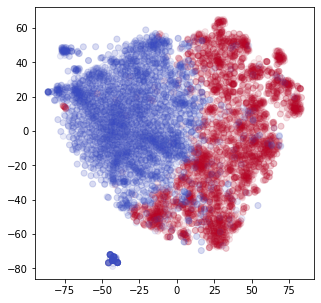

In [11]:
plt.figure(figsize=(5, 5))
plt.scatter(zs_emb[:,0], zs_emb[:,1], c=label_zs, alpha=0.1, cmap='coolwarm');

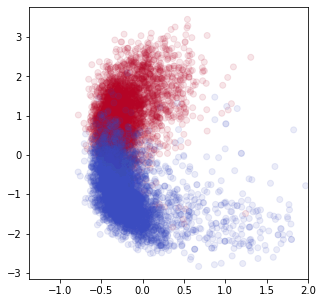

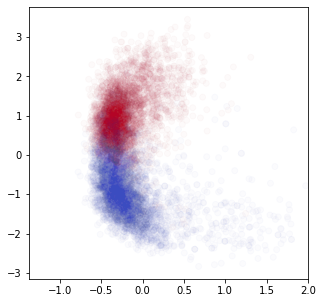

In [21]:
# PCA
zs = np.concatenate((z_tests['real'], z_tests['fake']))
label_zs = np.array([1] * z_tests['real'].shape[0] + [0] * z_tests['fake'].shape[0])
zs_emb = PCA(n_components=2).fit_transform(zs)

for alpha in [0.1, 0.02]:
    plt.figure(figsize=(5, 5))
    plt.scatter(zs_emb[:,0], zs_emb[:,1], c=label_zs, alpha=alpha, cmap='coolwarm');
    plt.xlim(None, 2); 
    # plt.ylim(-1.1, 2.);

# Linear Evaluation

In [65]:
# freeze(model)
# model.eval();

In [8]:
# # data loader
# batch_size = 128
# num_workers = 12
# train_data_loader, test_data_loader = build_data_pipeline(batch_size, num_workers, tokenizer)

In [6]:
# linear clf head
dim = 768
linear = nn.Linear(dim, 2, )
linear = linear.to(device)

# compile
n_epochs = 2
criterion = nn.CrossEntropyLoss()  #nn.BCEWithLogitsLoss() 
optimizer = torch.optim.AdamW(linear.parameters(), lr=1e-3, weight_decay=1e-5)
T_max = int(np.ceil(len(train_data_loader.dataset) // batch_size)) * n_epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

print(T_max)

560


In [7]:
# train
steps = 0
for epoch in range(n_epochs):
    print('EPOCH:', epoch)
    for i, batch in enumerate(train_data_loader):
        optimizer.zero_grad()
        
        sents, X, Y = batch  # fetch data
        out = model(**X.to(device))  # forward
        if normalize:
            normalize_last_hidden_state(out)
        aggregate_last_hidden_state(X, out, 'pytorch')  # `last_hidden_state`: (B, D)
        
        out = linear(out['last_hidden_state'])
        loss = criterion(out.squeeze().float(), Y.to(device).long())
                
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # verbose
        steps += 1
        current_lr = optimizer.param_groups[0]['lr']
        print(f'step: {steps}, train/loss.step: {round(loss.item(), 5)}, lr: {current_lr}')
        

EPOCH: 0
step: 1, train/loss.step: 0.70009, lr: 0.0009999921320324326
step: 2, train/loss.step: 0.68343, lr: 0.0009999685283773503
step: 3, train/loss.step: 0.66264, lr: 0.000999929189777604
step: 4, train/loss.step: 0.64496, lr: 0.0009998741174712532
step: 5, train/loss.step: 0.61994, lr: 0.0009998033131915264
step: 6, train/loss.step: 0.62545, lr: 0.0009997167791667666
step: 7, train/loss.step: 0.5817, lr: 0.0009996145181203613
step: 8, train/loss.step: 0.58061, lr: 0.0009994965332706571
step: 9, train/loss.step: 0.56178, lr: 0.0009993628283308578
step: 10, train/loss.step: 0.54161, lr: 0.000999213407508908
step: 11, train/loss.step: 0.52438, lr: 0.0009990482755073602
step: 12, train/loss.step: 0.55461, lr: 0.0009988674375232276
step: 13, train/loss.step: 0.51719, lr: 0.0009986708992478198
step: 14, train/loss.step: 0.4889, lr: 0.0009984586668665635
step: 15, train/loss.step: 0.5088, lr: 0.000998230747058809
step: 16, train/loss.step: 0.46784, lr: 0.000997987146997619
step: 17, train

step: 134, train/loss.step: 0.13699, lr: 0.0008652514554406379
step: 135, train/loss.step: 0.14887, lr: 0.0008633301610170127
step: 136, train/loss.step: 0.19359, lr: 0.000861397431913695
step: 137, train/loss.step: 0.18759, lr: 0.0008594533289572844
step: 138, train/loss.step: 0.22443, lr: 0.0008574979133323369
step: 139, train/loss.step: 0.23107, lr: 0.0008555312465794395
step: 140, train/loss.step: 0.21305, lr: 0.000853553390593273
step: 141, train/loss.step: 0.18016, lr: 0.0008515644076206644
step: 142, train/loss.step: 0.15663, lr: 0.0008495643602586279
step: 143, train/loss.step: 0.16467, lr: 0.0008475533114523946
step: 144, train/loss.step: 0.17388, lr: 0.0008455313244934315
step: 145, train/loss.step: 0.15334, lr: 0.0008434984630174499
step: 146, train/loss.step: 0.15535, lr: 0.0008414547910024026
step: 147, train/loss.step: 0.15233, lr: 0.0008394003727664702
step: 148, train/loss.step: 0.13194, lr: 0.0008373352729660364
step: 149, train/loss.step: 0.2224, lr: 0.000835259556593

step: 265, train/loss.step: 0.14091, lr: 0.000542025262464623
step: 266, train/loss.step: 0.21057, lr: 0.0005392295478639217
step: 267, train/loss.step: 0.13208, lr: 0.0005364325986359793
step: 268, train/loss.step: 0.1214, lr: 0.0005336345028060191
step: 269, train/loss.step: 0.13274, lr: 0.0005308353484353499
step: 270, train/loss.step: 0.1121, lr: 0.000528035223618595
step: 271, train/loss.step: 0.1649, lr: 0.0005252342164809195
step: 272, train/loss.step: 0.09741, lr: 0.0005224324151752567
step: 273, train/loss.step: 0.10839, lr: 0.0005196299078795335
step: 274, train/loss.step: 0.16814, lr: 0.0005168267827938962
step: 275, train/loss.step: 0.13214, lr: 0.0005140231281379336
step: 276, train/loss.step: 0.12941, lr: 0.0005112190321479017
step: 277, train/loss.step: 0.11414, lr: 0.0005084145830739454
step: 278, train/loss.step: 0.13541, lr: 0.0005056098691773222
step: 279, train/loss.step: 0.11631, lr: 0.000502804978727624
step: 280, train/loss.step: 0.13502, lr: 0.000499999999999999

step: 395, train/loss.step: 0.16166, lr: 0.00019934145435079677
step: 396, train/loss.step: 0.08429, lr: 0.00019710497807958968
step: 397, train/loss.step: 0.10642, lr: 0.00019487803448121785
step: 398, train/loss.step: 0.13419, lr: 0.00019266069364176102
step: 399, train/loss.step: 0.08264, lr: 0.00019045302534508274
step: 400, train/loss.step: 0.15652, lr: 0.00018825509907063287
step: 401, train/loss.step: 0.11725, lr: 0.00018606698399126236
step: 402, train/loss.step: 0.10591, lr: 0.0001838887489710448
step: 403, train/loss.step: 0.14606, lr: 0.00018172046256311047
step: 404, train/loss.step: 0.14716, lr: 0.00017956219300748754
step: 405, train/loss.step: 0.10742, lr: 0.0001774140082289559
step: 406, train/loss.step: 0.12961, lr: 0.00017527597583490783
step: 407, train/loss.step: 0.10672, lr: 0.0001731481631132216
step: 408, train/loss.step: 0.13858, lr: 0.00017103063703014336
step: 409, train/loss.step: 0.16877, lr: 0.0001689234642281789
step: 410, train/loss.step: 0.08359, lr: 0.0

step: 525, train/loss.step: 0.12264, lr: 9.607359798384762e-06
step: 526, train/loss.step: 0.12665, lr: 9.067852381940778e-06
step: 527, train/loss.step: 0.09804, lr: 8.543795518357746e-06
step: 528, train/loss.step: 0.1127, lr: 8.035205700685147e-06
step: 529, train/loss.step: 0.13281, lr: 7.5420989351958995e-06
step: 530, train/loss.step: 0.12778, lr: 7.06449074088204e-06
step: 531, train/loss.step: 0.18157, lr: 6.602396148966778e-06
step: 532, train/loss.step: 0.11454, lr: 6.155829702431156e-06
step: 533, train/loss.step: 0.13008, lr: 5.7248054555563564e-06
step: 534, train/loss.step: 0.17835, lr: 5.309336973481669e-06
step: 535, train/loss.step: 0.10782, lr: 4.909437331777165e-06
step: 536, train/loss.step: 0.13144, lr: 4.525119116032638e-06
step: 537, train/loss.step: 0.10705, lr: 4.156394421460919e-06
step: 538, train/loss.step: 0.16003, lr: 3.8032748525179584e-06
step: 539, train/loss.step: 0.08999, lr: 3.4657715225368446e-06
step: 540, train/loss.step: 0.14045, lr: 3.1438950533

In [8]:
# empty cuda cache
del X, Y
torch.cuda.empty_cache()

In [9]:
# test
acc_score = 0
n_test_samples = 0
for i, batch in enumerate(test_data_loader):
    print(round(i/len(test_data_loader) * 100, 1), '%')
    
    sents, X, Y = batch  # fetch data
    out = model(**X.to(device))  # forward
    if normalize:
        normalize_last_hidden_state(out)
    aggregate_last_hidden_state(X, out, 'pytorch')  # `last_hidden_state`: (B, D)

    out = linear(out['last_hidden_state'])
    out = torch.softmax(out, dim=1)
    out = torch.argmax(out, dim=1)

    out = out.squeeze().detach().cpu().numpy()
    Y = Y.numpy()
    
    #out = (torch.sigmoid(torch.from_numpy(out)).numpy() >= 0.5).astype(int)
    acc_score += accuracy_score(Y, out, normalize=False)
    n_test_samples += len(Y)

0.0 %
1.4 %
2.8 %
4.2 %
5.6 %
7.0 %
8.5 %
9.9 %
11.3 %
12.7 %
14.1 %
15.5 %
16.9 %
18.3 %
19.7 %
21.1 %
22.5 %
23.9 %
25.4 %
26.8 %
28.2 %
29.6 %
31.0 %
32.4 %
33.8 %
35.2 %
36.6 %
38.0 %
39.4 %
40.8 %
42.3 %
43.7 %
45.1 %
46.5 %
47.9 %
49.3 %
50.7 %
52.1 %
53.5 %
54.9 %
56.3 %
57.7 %
59.2 %
60.6 %
62.0 %
63.4 %
64.8 %
66.2 %
67.6 %
69.0 %
70.4 %
71.8 %
73.2 %
74.6 %
76.1 %
77.5 %
78.9 %
80.3 %
81.7 %
83.1 %
84.5 %
85.9 %
87.3 %
88.7 %
90.1 %
91.5 %
93.0 %
94.4 %
95.8 %
97.2 %
98.6 %


In [10]:
# empty cuda cache
del X, Y
torch.cuda.empty_cache()

In [11]:
print("TEST ACC:", round(acc_score / n_test_samples, 3))

TEST ACC: 0.969


# CAM

In [12]:
def GAPpool(X, out, kind='numpy'):
    assert kind in ['numpy', 'pytorch']
    attention_mask = X['attention_mask'][:, :, None]
    out *= attention_mask
    
    if kind == 'numpy':
        out = np.sum(out, axis=1)  # (B, D)
        out /= np.sum(attention_mask, axis=1)  # (B, D)
    else:
        out = torch.sum(out, dim=1)  # (B, D)
        out /= torch.sum(attention_mask, dim=1)  # (B, D)
    return out

In [13]:
embeddings = model.embeddings.word_embeddings

In [14]:
# test
hist = {}
for i, batch in enumerate(test_data_loader):
    print(round(i/len(test_data_loader) * 100, 1), '%')
    
    sents, X, Y = batch  # fetch data
    
    # forward
    out = model(**X.to(device))  
    Zprime = embeddings(X['input_ids'].to(device))  # (B, L, D)
    #hist['Zprime'] = GAPpool(X, Zprime, kind='pytorch').cpu().numpy()
    hist['Zprime'] = Zprime.cpu().numpy()
    
    if normalize:
        normalize_last_hidden_state(out)
    hist['last_hidden_state'] = out['last_hidden_state'].clone().detach().cpu().numpy() # (B, L, D)
    aggregate_last_hidden_state(X, out, 'pytorch')  # `last_hidden_state`: (B, D)

    out = linear(out['last_hidden_state'])  # (B, 2)
    out = torch.softmax(out, dim=1)  # (B, 2)

    out = out.squeeze().detach().cpu().numpy()
    Y = Y.numpy()
    
    # store
    hist['out'] = np.copy(out)
    hist['Y'] = np.copy(Y)
    
    break
    
# empty cuda cache
del X, Y, Zprime
torch.cuda.empty_cache()

0.0 %


In [98]:
# select some random sample
rand_idx = np.random.randint(0, hist['last_hidden_state'].shape[0])

sent = sents[rand_idx]
h_state = hist['last_hidden_state'][rand_idx]  # (L, D)
W = linear.weight.data.cpu().T  # (D, 2)
y = hist['Y'][rand_idx]
yhat = hist['out'].argmax(axis=1)[rand_idx]

print('LABEL:', 'FAKE' if y == 0 else 'REAL')
print('[pred] LABEL:', 'FAKE' if yhat == 0 else 'REAL')

LABEL: FAKE
[pred] LABEL: FAKE


In [86]:
# delibarely make the model give attention for "FAKE" on a REAL sentence. (or VICE VERSA)
# y = 0

In [99]:
# compute the CAM score for each token 
Mc = None  # (L,)
for d in range(h_state.shape[1]):
    fk = h_state[:,d]  # (L,)
    wk = W[d, y]  # constant
    if Mc is None:
        Mc = wk * fk
    else:
        Mc += wk * fk
Mc = Mc.numpy()

In [100]:
# clipc `Mc` (CAM score) by the sentence token length
sent_token_len = len(tokenizer.convert_ids_to_tokens(tokenizer(sent)['input_ids']))
Mc = Mc[:sent_token_len]

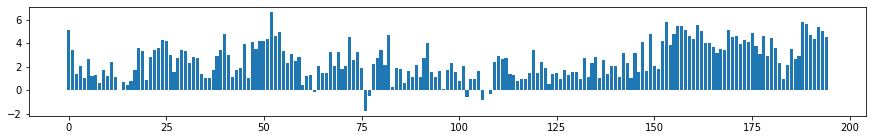

In [101]:
plt.figure(figsize=(15,2))
plt.bar(np.arange(len(Mc)), Mc);

In [102]:
# original sentence
print(sent)

the show went on last night even though protesters attempted to get trump dumped from hosting. in true trump style he was able to laugh at himself and make fun of the protest against him. he turned this into ratings gold for snl and made us all laugh out loud the faux outrage and twisting of trump s words on immigration continued outside the saturday night live studio last night: the presidential candidate hosted  saturday night live  this week, turning his controversial appearance into both a punchline and a reality.much like on the campaign trail, the republican frontrunner didn t hold back during his monologue, diving right into jokes about rosie o donnell, protesters angry about his hosting the show and even fielding an interruption from larry david:larry david couldn't miss this opportunity. #snl https://t.co/cq3y2bxutk  saturday night live (@nbcsnl) november 8, 2015  dad-dancing is cool: via: nbc


In [103]:
# reconstructed sentence with attention score as color
topk_rate = 0.1
topk = torch.topk(torch.from_numpy(Mc), k=int(sent_token_len * topk_rate), largest=True)
recons_sent = ''
tokens = []
for i, token in enumerate(tokenizer.convert_ids_to_tokens(tokenizer(sent)['input_ids'])[:tokenizer.model_max_length]):
    tokens.append(token)
    if i in topk.indices:
        recons_sent = recons_sent + f'{Fore.RED}{token}{Style.RESET_ALL}' + ' '
    else:
        recons_sent = recons_sent + token + ' '
        
print(topk, end='\n\n')
print(recons_sent)

torch.return_types.topk(
values=tensor([6.6524, 5.8382, 5.8008, 5.6388, 5.5551, 5.4511, 5.4243, 5.3997, 5.1312,
        5.1275, 5.1176, 5.0488, 5.0019, 4.9832, 4.8573, 4.8187, 4.8135, 4.7682,
        4.7336]),
indices=tensor([ 52, 188, 153, 189, 161, 156, 157, 192, 169, 158,   0, 162, 193,  54,
        175, 155, 149,  40, 190]))

[CLS] the show went on last night even though protesters attempted to get trump dumped from hosting . in true trump style he was able to laugh at himself and make fun of the protest against him . he turned this into ratings gold for s ##nl and made us all laugh out loud the faux outrage and twisting of trump s words on immigration continued outside the saturday night live studio last night : the presidential candidate hosted saturday night live this week , turning his controversial appearance into both a punch ##line and a reality . much like on the campaign trail , the republican front ##runner didn t hold back during his mono ##logue , diving right into joke

<b> Things we can do </b>
- See the attended words.
- See where the model would look if the REAL sentence were to be treated as FAKE. (vice versa)
    - CAM scores are significantly different.

### Correlation matrix of word tokens in a given sentence.

In [58]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [59]:
import pandas as pd
import seaborn as sns

def plot_corr(in_vectors, tokens):
    """
    :param in_vectors: (L, D)
    """
    df = pd.DataFrame(torch.corrcoef(torch.from_numpy(in_vectors)).numpy())
    df.columns = tokens
    df.index = tokens

    # plot
    fig, ax = plt.subplots(figsize=(17,10))
    ax.xaxis.tick_top()
    labels = np.round(df, 2).values.astype(str)
    ax = sns.heatmap(df, cmap="jet", annot=labels, annot_kws={'fontsize': 10}, fmt='s')
    plt.tight_layout()
    plt.show()

In [60]:
max_len_tokens = 30

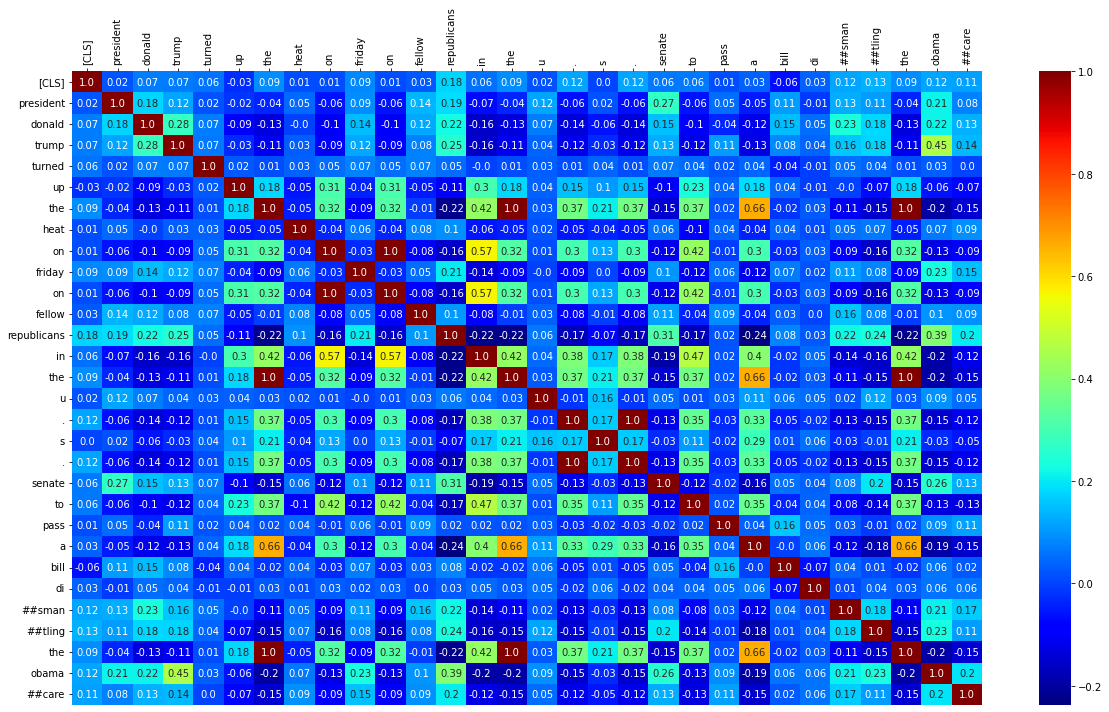

In [61]:
# Z'
in_vectors = hist['Zprime'][rand_idx, :max_len_tokens, :]
plot_corr(in_vectors, tokens[:max_len_tokens])

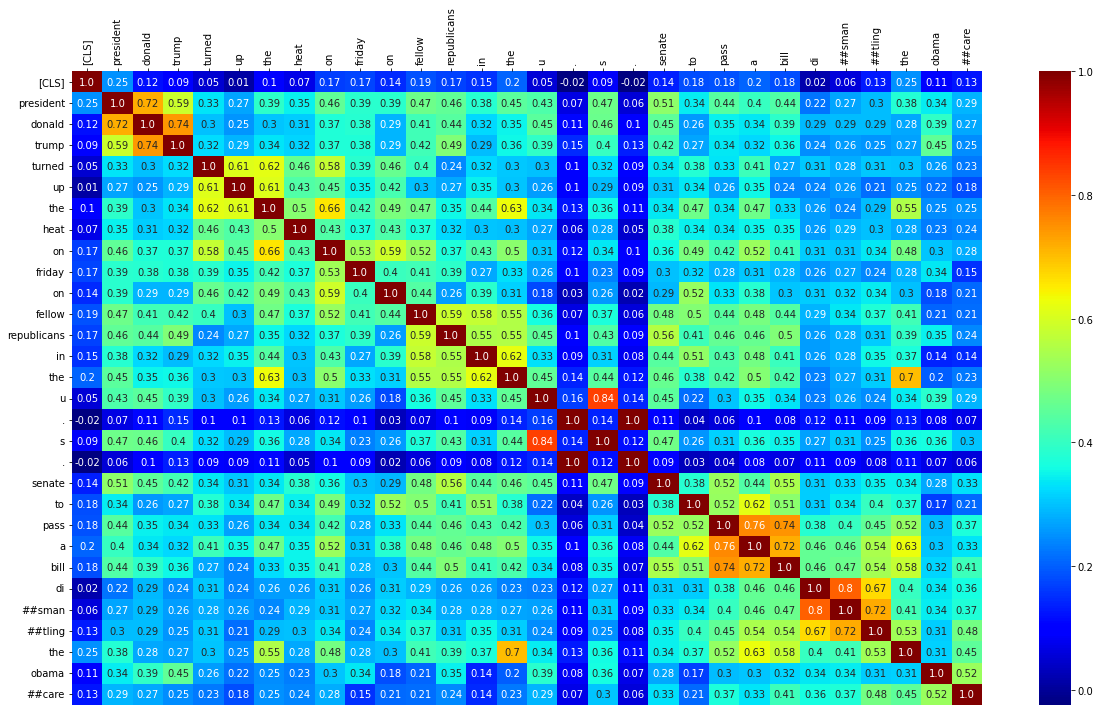

In [62]:
# Z'_B
in_vectors = hist['last_hidden_state'][rand_idx, :max_len_tokens, :]
plot_corr(in_vectors, tokens[:max_len_tokens])